In [1]:
import os.path as op
import time
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tools
from imp import reload
reload(tools)
from tools import syn_registration, affine_registration
%matplotlib inline


import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
import dipy.data as dpd

In [2]:
import nibabel as nib
import dipy.data as dpd
import os

In [3]:
afqpath = '/Users/arokem/source/AFQ/'
# afqpath = '/home/jyeatman/git/afq'

In [4]:
ni, gtab = dpd.read_stanford_hardi()

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/stanford_hardi 


In [5]:
hardi_data = ni.get_data()
hardi_affine = ni.get_affine()

In [6]:
b0 = hardi_data[..., gtab.b0s_mask]

In [7]:
mean_b0 = np.mean(b0, -1)

In [8]:
ni_b0 = nib.Nifti1Image(mean_b0, hardi_affine)

In [9]:
ni_b0.to_filename('mean_b0.nii')

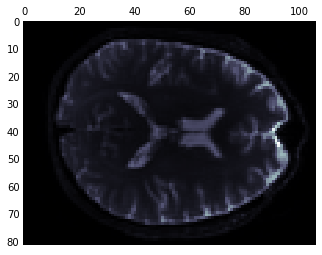

In [10]:
plt.matshow(mean_b0[:,:,mean_b0.shape[-1]//2], cmap=cm.bone)

In [11]:
dpd.fetch_mni_template()

Data size is approximately 35MB
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/mni_template 


({'COPYING': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33312/COPYING',
   '6e2168072e80aa4c0c20f1e6e52ec0c8'),
  'mni_icbm152_t1_tal_nlin_asym_09a.nii': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33312/mni_icbm152_t1_tal_nlin_asym_09a.nii',
   '1ea8f4f1e41bc17a94602e48141fdbc8'),
  'mni_icbm152_t2_tal_nlin_asym_09a.nii': ('https://digital.lib.washington.edu/researchworks/bitstream/handle/1773/33312/mni_icbm152_t2_tal_nlin_asym_09a.nii',
   'f41f2e1516d880547fbf7d6a83884f0d')},
 '/Users/arokem/.dipy/mni_template')

In [12]:
MNI_T2 = dpd.read_mni_template()

Data size is approximately 35MB
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/arokem/.dipy/mni_template 


In [13]:
MNI_T2_data = MNI_T2.get_data()

In [14]:
MNI_T2_affine = MNI_T2.get_affine()

In [15]:
#xformed_b0, affine = affine_registration(mean_b0, MNI_T2_data, 
#                                         moving_grid2world=hardi_affine, 
#                                         static_grid2world=MNI_T2_affine)

In [16]:
#plt.matshow(xformed_b0[:, :, xformed_b0.shape[-1]//2], cmap=cm.bone)
#plt.matshow(MNI_T2_data[:, :, MNI_T2_data.shape[-1]//2], cmap=cm.bone)

In [17]:
warped_b0, mapping = syn_registration(mean_b0, MNI_T2_data,
                                      moving_grid2world=hardi_affine, 
                                      static_grid2world=MNI_T2_affine, 
                                      #step_length=0.1,
                                      #sigma_diff=2.0,
                                      metric='CC', dim=3, level_iters = [10, 10, 5], 
                                      #prealign=affine.affine)
                                      prealign=None)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


/Users/arokem/source/dipy/dipy/align/imwarp.py:441: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  W = None if image_world2grid == 'identity' else image_world2grid
/Users/arokem/source/dipy/dipy/align/imwarp.py:444: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  S = None if out_grid2world == 'identity' else out_grid2world


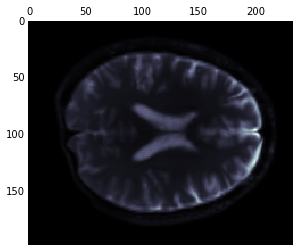

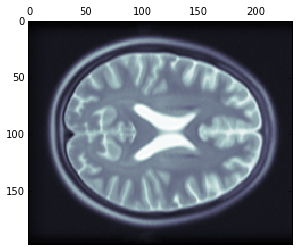

In [18]:
plt.matshow(warped_b0[:,:,warped_b0.shape[-1]//2], cmap=cm.bone)
plt.matshow(MNI_T2_data[:, :, MNI_T2_data.shape[-1]//2], cmap=cm.bone)

In [19]:
new_ni = nib.Nifti1Image(warped_b0, MNI_T2_affine)

In [20]:
new_ni.to_filename('./warped_b0.nii.gz')

In [21]:
LOCC_ni = nib.load(os.path.join(afqpath,'templates/callosum2/L_Occipital.nii.gz'))
ROCC_ni = nib.load(os.path.join(afqpath,'templates/callosum2/R_Occipital.nii.gz'))
midsag_ni = nib.load(os.path.join(afqpath,'templates/callosum2/Callosum_midsag.nii.gz'))

In [22]:
LOCC_data = LOCC_ni.get_data()
ROCC_data = ROCC_ni.get_data()
midsag_data = midsag_ni.get_data()

In [23]:
import scipy.ndimage as ndim

In [24]:
dilated_midsag = ndim.binary_dilation(midsag_data)

In [25]:
midsag_affine = midsag_ni.get_affine()

In [26]:
#warped_midsag = mapping.transform_inverse(midsag_data)

In [27]:
dilated_midsag.astype(int)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, 

In [28]:
warped_midsag = mapping.transform_inverse(ndim.binary_dilation(midsag_data).astype(int), interpolation='nearest')
warped_LOCC = mapping.transform_inverse(ndim.binary_dilation(LOCC_data).astype(int), interpolation='nearest')
warped_ROCC = mapping.transform_inverse(ndim.binary_dilation(ROCC_data).astype(int), interpolation='nearest')


/Users/arokem/source/dipy/dipy/align/imwarp.py:329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  W = None if image_world2grid == 'identity' else image_world2grid
/Users/arokem/source/dipy/dipy/align/imwarp.py:332: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  S = None if out_grid2world == 'identity' else out_grid2world


In [29]:
#bin_warped_LOCC = np.ceil(warped_LOCC)
bin_warped_midsag = np.ceil(warped_midsag)

In [30]:
im = np.sum(np.ceil(bin_warped_midsag), axis=0)

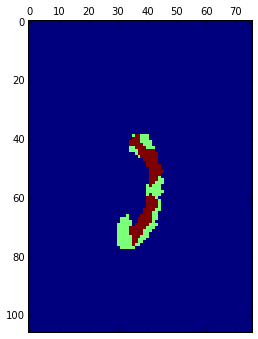

In [31]:
plt.matshow(im)

In [32]:
import scipy.ndimage as ndim

In [33]:
#filled_warped_LOCC= ndim.binary_dilation(bin_warped_LOCC, iterations=1).astype(int)
filled_warped_midsag= ndim.binary_fill_holes(bin_warped_midsag.astype(int)).astype(int)

In [34]:
np.unique(filled_warped_midsag)

array([0, 1])

In [35]:
filled_warped_midsag.shape

(81, 106, 76)

In [36]:
filled_warped_midsag_ni = nib.Nifti1Image(filled_warped_midsag, hardi_affine)

In [37]:
filled_warped_midsag_ni.to_filename('./warped_midsag.nii.gz')

In [38]:
im = np.sum(np.ceil(ndim.binary_fill_holes(filled_warped_midsag)), axis=0)

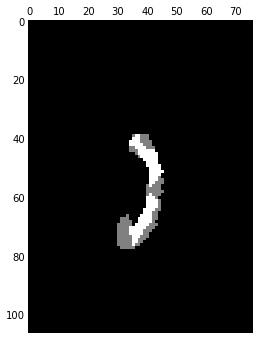

In [39]:
plt.matshow(im, cmap=cm.gray)

In [40]:
sl_from_file = nib.trackvis.read('./csa_white_matter.trk', points_space='rasmm')

In [41]:
all_sl = [s[0] for s in sl_from_file[0]]

In [42]:
xform_sl = [s for s in dtu.move_streamlines(all_sl, np.linalg.inv(hardi_affine)) if s.shape[0]>10]

In [43]:
len(xform_sl)

499293

In [44]:
select_sl = xform_sl
ROIs = [warped_midsag, warped_LOCC, warped_ROCC]
t0 = time.time()
for r in ROIs:
    select_sl = dts.select_by_rois(select_sl, [r.astype(bool)], [True])

select_sl = list(select_sl)
t1 = time.time()
print(t1 - t0)

172.804683924


In [59]:
import dipy.tracking.streamline as dts

In [68]:
select_sl = dts.orient_by_rois(select_sl, ROIs[0], ROIs[1])

In [69]:
## Would it be faster to generate the first operation and then generate each successive one? 

## 

In [70]:
t0 = time.time()
select_sl = [s for s in select_sl]
t1 = time.time()
print(t1 - t0)

0.000892162322998


In [71]:
len(select_sl)

3831

In [72]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

In [73]:
ren = fvtk.ren()
fvtk.add(ren, fvtk.line(select_sl, line_colors(select_sl)))
fvtk.record(ren, n_frames=1, out_path='callosal_tracks.png', size=(600, 600))
LOCC_ROI_actor = fvtk.contour(warped_LOCC, levels=[1], colors=[(1., 1., 0.)],
                            opacities=[1.])

#ROCC_ROI_actor = fvtk.contour(warped_ROCC, levels=[1], colors=[(1., 1., 0.)],
#                            opacities=[1.])

cc_ROI_actor = fvtk.contour(warped_midsag, levels=[1], colors=[(1., 1., 0.)],
                            opacities=[1.])


for act in [cc_ROI_actor, LOCC_ROI_actor]:#, ROCC_ROI_actor]:
    fvtk.add(ren, act)

fvtk.show(ren)

In [74]:
import IPython.display as display

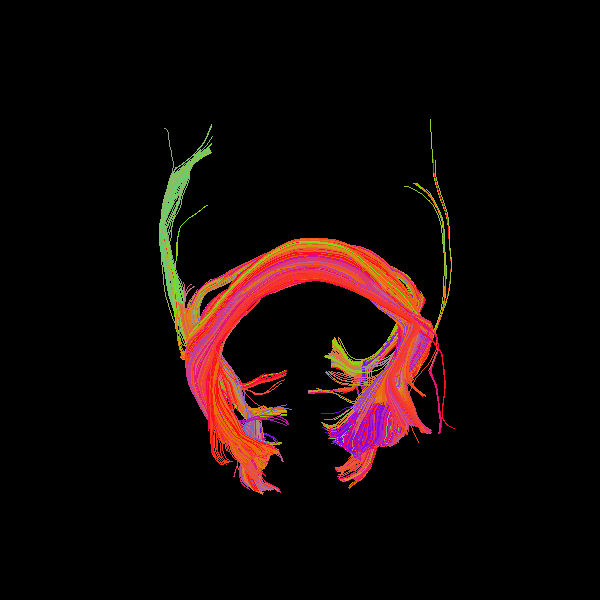

In [75]:
display.Image(filename='callosal_tracks.png')

In [77]:
len(select_sl)

3831

In [78]:
import dipy.tracking.streamlinespeed as speed

In [79]:
fgarray = np.array(speed.set_number_of_points(select_sl, 100))

fgarray.shape

fcore = np.median(fgarray,axis=0)
fcore.shape

(100, 3)

In [81]:
fgarray.shape

(3831, 100, 3)

In [ ]:
fvtk.line?

In [83]:
ren = fvtk.ren()
fvtk.add(ren, fvtk.line([s for s in fgarray], [0, .5, 1],opacity=.1))
fvtk.add(ren, fvtk.line(fcore, [1, 1, 0],opacity=1, linewidth = 5))
fvtk.record(ren, n_frames=1, out_path='callosal_tracks.png', size=(600, 600))
LOCC_ROI_actor = fvtk.contour(warped_LOCC, levels=[1], colors=[(1., 1., 0.)],
                            opacities=[1.])

#ROCC_ROI_actor = fvtk.contour(warped_ROCC, levels=[1], colors=[(1., 1., 0.)],
#                            opacities=[1.])

cc_ROI_actor = fvtk.contour(warped_midsag, levels=[1], colors=[(1., 1., 0.)],
                            opacities=[1.])


for act in [cc_ROI_actor, LOCC_ROI_actor]:#, ROCC_ROI_actor]:
    fvtk.add(ren, act)

fvtk.show(ren)

In [ ]:
fcore.shape

In [ ]:
fig, ax = plt.subplots(10, 10)
fig.set_size_inches([20, 20])
for n in range(100):
    i = np.mod(n, 10)
    j = n / 10.
    ax[i, j].plot(fgarray[:,n,0],fgarray[:,n,2],'o')
    ax[i, j].plot(fcore[n,0],fcore[n,2],'ro',markersize=20)